In [54]:
import networkx as nx
import numpy as np 
import matplotlib.pyplot as plt

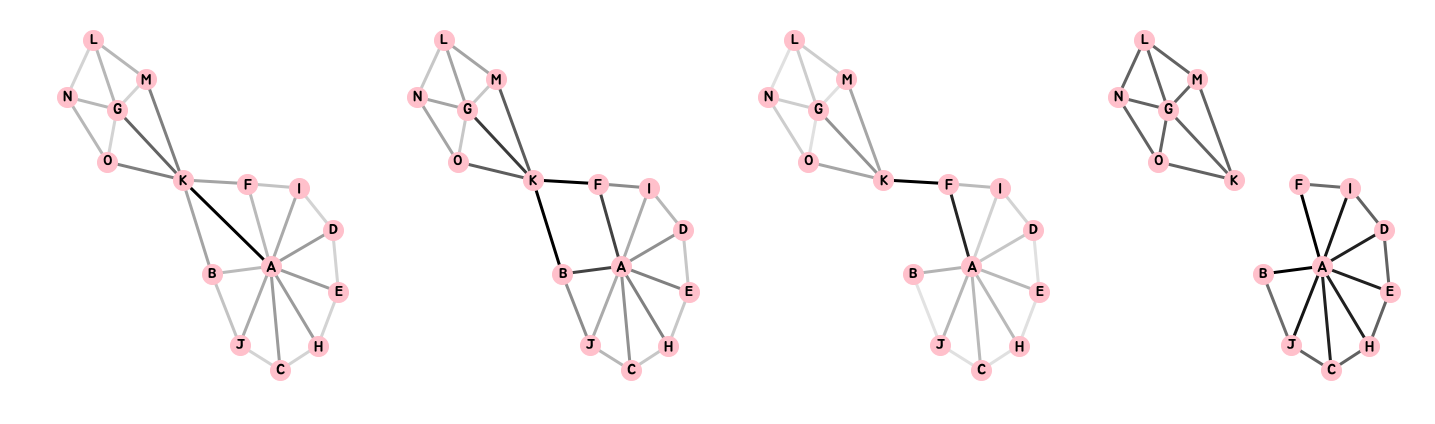

In [179]:
## 테스트 그래프 생성
G = nx.Graph()
G.add_nodes_from([chr(c) for c in range(ord('A'), ord('A')+15)])
# add edge
G.add_edges_from([('A', n) for n in list(G.node())[:10]])
G.add_edges_from([('G', n) for n in list(G.node())[11:]])
G.add_edges_from([('B', 'J'), ('C', 'J'), ('C', 'H'), ('H', 'E'), ('E', 'D'), ('D', 'I'), 
                  ('I', 'F'), ('B', 'K'), ('K', 'F')])
G.add_edges_from([('O', 'N'), ('N', 'L'), ('M', 'L'), ('O', 'K'), ('K', 'M')])
G.add_edges_from([('A', 'K'), ('G', 'K')])
G.remove_edge('A', 'G'), 
#pos = nx.spring_layout(G)
#G.remove_node('K')
#G.remove_nodes_from(['A', 'G'])
####
f, axes = plt.subplots(1, 4, sharex=True, sharey=True)
f.set_size_inches((20, 6)) 
i=0
while True:
    #ax = axes[i//2][i%2]
    ax = axes[i]
    nx.draw_networkx_nodes(G, pos, node_shape='o', node_size=400, 
                           node_color='pink', ax=ax
                           #node_color=['Red' if n is 'K' else 'pink'  for n in G.nodes()]
                          )
    #edge_color_lst = list(nx.edge_betweenness_centrality(G).values())
    #edge_color_lst = [(ec)/(max(edge_color_lst) - min(edge_color_lst)) for ec in edge_color_lst]
    nx.draw_networkx_edges(G, pos, width = 3, 
                           edge_cmap = plt.cm.binary, ## 그냥 cmap이 아니라 edge_cmap으로 넘겨야 함 
                           edge_color = list(nx.edge_betweenness_centrality(G).values()), 
                           edge_vmin=-0.05, ax=ax
                           #edge_vmin=0, edge_vmax=1.0
                          )
    ## font family에는 font_name이 들어가야 함. 블로그에 정리해둠
    nx.draw_networkx_labels(
            G, pos, font_family='BM JUA_OTF', font_color='black', font_size=15,
            ax=ax
        )
    #plt.axis('off')
    ax.set_axis_off()
    #plt.savefig('../../assets/images/markdown_img/180807_centrality_deg_bet_net.png', dpi=200)
    #plt.show()
    if nx.is_connected(G):
        r_edge = max(list(nx.edge_betweenness_centrality(G).items()), key=lambda x: x[1])[0]
        G.remove_edge(*r_edge)
        i+=1
    else:
        break
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180808_edge_bet_cent_cut.svg')
plt.show()

In [100]:
max(list(nx.edge_betweenness_centrality(G).items()), key=lambda x: x[1])[0]

('A', 'K')

In [1004]:
"""
- 필요한 라이브러리들은 모두 여기서 한번에 import 
- font 또한 여기서 한번에 정리한다. 
"""
import numpy as np 
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import itertools
from itertools import combinations
from collections import Counter, namedtuple

from oauth2client.service_account import ServiceAccountCredentials
import gspread

## fontproperties 설정
BMDOHYEON = fm.FontProperties(fname='/Users/frhyme/Library/Fonts/BMDOHYEON_otf.otf')
BMJUA = fm.FontProperties(fname='/Users/frhyme/Library/Fonts/BMJUA_otf.otf')
BMHANNA = fm.FontProperties(fname='/Users/frhyme/Library/Fonts/BMHANNA_11yrs_otf.otf')
SDMiSaeng = fm.FontProperties(fname='/Users/frhyme/Library/Fonts/SDMiSaeng.ttf')
nanum = fm.FontProperties(fname='/Library/Fonts/NanumSquareOTFB.otf')
TimesNewRoman = fm.FontProperties(fname='/Library/Fonts/Times New Roman.ttf')

## 구글 시트로부터, 파일을 읽고 리리스트에 정리해줌
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('/Users/frhyme/Downloads/My Project-6f3701259a8e.json', scope)
## authorize
gc = gspread.authorize(credentials).open("!individual_meet_report")
## sheet file 이름을 넘겨주고 읽습니다. 
wks0 = gc.get_worksheet(0)
wks1 = gc.get_worksheet(1)
all_rows = wks0.get_all_values()[1:] + wks1.get_all_values()[1:]

In [1005]:
raw_df = []
for row in all_rows:
    date, category = row[0], row[3].strip() 
    people = filter(lambda x: True if x.strip()!="" else False, row[4:]) ## 비어있는 셀 삭제 
    people = map(lambda x: x.strip(), people) ## 공백제거
    people = sorted(list(set(people))) ## 사람 이름 순으로 정렬해야 양방향성 서로다른 edge가 생기지 않음
    people.remove('이승훈')## 내가 들어있는 데이터는 무의미함. 
    raw_df.append((date, category, people))## 이렇게 정리하여 raw_df에 넣고 

## 데이터 프레임으로 변경하고, 정렬, index 리셋등 
## (date, category, people_lst)로 정리된 dataframe
raw_df = pd.DataFrame(raw_df, columns=['date', 'category', 'people'])
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df = raw_df.sort_values('date').reset_index(drop=True)

In [337]:
## 그래프 생성 
G = nx.Graph()
## add node 
G.add_nodes_from([(name, {'weight':count}) 
                  for name, count in Counter(itertools.chain.from_iterable(raw_df.people)).most_common()])
## add edge 
edges = []
for row in raw_df.people:
    ## 이미 위에서 정렬을 했지만, 그냥 한 번 더 해줌 깔깔 
    edges += [tuple(sorted([row[i], row[j]])) for i in range(0, len(row)-1) for j in range(i+1, len(row))]
G.add_edges_from([(edge[0], edge[1],{'weight':count}) for edge, count in Counter(edges).most_common()])
#G.add_weighted_edges_from(Counter(edges).most_common())

## 딱 한 번 만난 인맥은 지우자 
def remove_below_n_nodes(inputG, below_n):
    remove_nodes = filter(lambda n: True if n[1]['weight']<below_n else False, inputG.nodes(data=True))
    remove_nodes = map(lambda x: x[0], remove_nodes)
    inputG.remove_nodes_from(list(remove_nodes))
## 잘못 들어간 node를 지워주는 것이 필요한데, 이 부분은 작업하면서 일관적으로 해주는 것이 중요함. 
## 가장 긴 shortest_path를 찾은 다음, 거기에 포함된 양 쪽에 이상한 node가 들어있지 않은지 파악하는 것이 필요. 
G.remove_nodes_from(['김태웅', '김용중', '여자1', '여자2', '여자3', '여자4', '남자1', 
                     '박병후', '김근수', '여자2', '김동혁', '배미라', '이유진', '정원욱', '이지수', 
                     '스물한살_여자', '남자_연일고_국어교사', 
                    ])
## 이상한 몇 가지 node를 지우자 
## 누군지 기억이 잘 나지 않는 node는 지워야 합니다. 
# G.remove_nodes_from(remove_node)

In [517]:
## 시각화를 위해서 weight 10 이하의 node는 자르자 
tempG = G.copy()
tempG.remove_nodes_from([n[0] for n in tempG.nodes(data=True) if n[1]['weight']<=10])
len(tempG.nodes())
tempG.add_edge('김태훈', '유선겸'), 
tempG.edges[('김태훈', '유선겸')]['weight']=1

In [ ]:
for i, comm in enumerate(community_lst[-1]):
    print(comm)
    for p in comm: 
        tempG.nodes()[p]['community'] = i 
[n[1]['community'] for n in tempG.nodes(data=True)]
print()

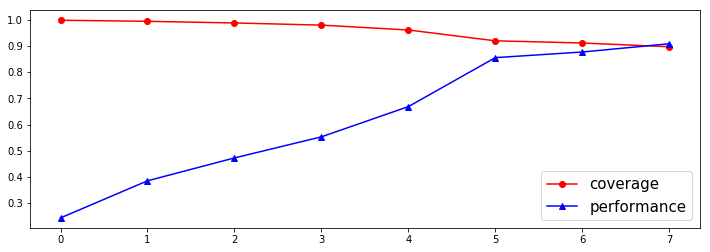

In [905]:
## community 

import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
#from networkx.algorithms.community.asyn_fluidc import asyn_fluidc
from networkx.algorithms.community import coverage, performance

community_lst = [] ## 커뮤니티 리스트 
coverage_lst, performance_lst = [], [] 
## 커뮤니티가 얼마나 잘 뽑혔는지를 평가하는 지표

for i, comms in enumerate(girvan_newman(tempG)):
    ## performance의 변화폭이 많이 적어지면 더이상 cluster를 나누어도 이득이 없으므로 멈춤
    if i!=0 and abs(performance(tempG, comms) - performance_lst[-1])< 0.01:
        break
    else:
        community_lst.append(comms), 
        coverage_lst.append(coverage(tempG, comms)), performance_lst.append(performance(tempG, comms))

## performance, coverage의 값을 확인한 다음 
## performance의 변화 폭이 작고, coverage가 충분히 클 때까지 자름
plt.figure(figsize=(12, 4))
plt.plot(coverage_lst, label='coverage', marker='o', color='r')
plt.plot(performance_lst, marker='^', label='performance', color='b')
plt.legend(fontsize=15)
plt.savefig('../../assets/images/markdown_img/180809_network_performance_coverage.svg')
plt.show()



In [684]:
for s in community_lst[-1]:
    print(s)
print(len(community_lst[-1]))
## '연구실 사람들과 학과', '동아리1', '독서모임1', '가족', '훈련소', '개발모임', '동아리2' '독서모임2', '학과동기'

{'김동석', '유세환', '조지현', '기완욱', '손영섭', '유온유', '이준호', '임정은', '이진연', '한은지', '홍준택', '남성현', '윤진성', '김대수', '김진우', '최인준', '김호겸', '이주석', '윤정현', '유택호', '김정택', '성상현', '임지택', '조민수', '이치헌', '백상현', '정윤선', '홍성철', '지봉준', '김한성', '이승록', '송민석'}
{'정화평', '이용문', '김건우', '황보순호', '김태훈', '류재현', '김대환', '김성래', '엄호용', '김규현', '민성용', '이기현', '서동진', '이태선', '이승렬', '빈영욱', '김준성', '권우경', '류성남', '이지환', '이동근'}
{'천은영', '김미현', '명진연', '조항현', '마리', '소담', '윤밍밍', '고철민', '강지우'}
{'김예원', '어머니', '이정호', '김재윤', '임소희', '송인영'}
{'이원형', '최수호', '유선겸', '송승민', '한주호', '서주환', '김범진', '윤석민', '김수빈'}
{'최혜진', '김성환', '박제현', '김영우', '안태훈', '장태웅', '박소연', '조성원', '송종혁'}
{'이시영', '신평식', '노명현', '윤치호', '엄태웅', '김상훈', '임석일', '김준연', '김범연', '양유동'}
{'진태원', '이동은', '박병희', '우성현', '이수현', '김수진'}
{'김해나', '정민우', '강보라', '문희경'}
9


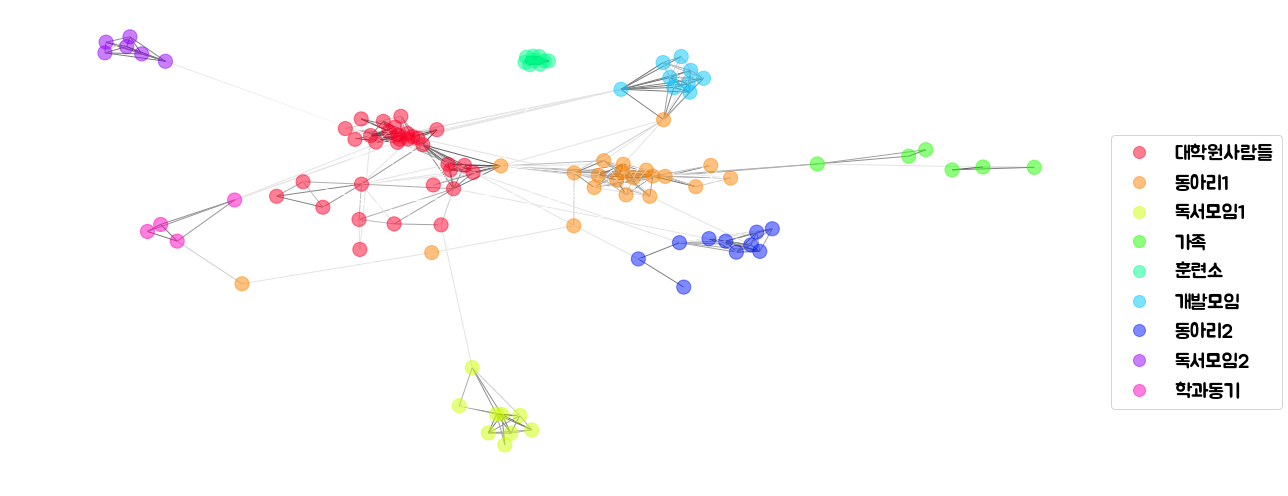

In [878]:
## 원래 그래프의 노드의 attribute에 community 정보를 넘겨줌
selected_community = community_lst[-1]
for i, comm in enumerate(selected_community):
    for p in comm: 
        tempG.nodes()[p]['community'] = i 

## 이제 그림을 그려줌 

plt.figure(figsize=(18, 7))
#pos = nx.spring_layout(tempG)


## 아래처럼 노드별로 label을 먹여서 따로 그려줘도 안됨
## plt.legend를 찍으면 모든 node가 서로 다른 것처럼 표시됨. 
nx.draw_networkx_nodes(tempG, pos=pos, node_size = 200,
                       node_color = [n[1]['community'] for n in tempG.nodes(data=True)], 
                       cmap=plt.cm.gist_rainbow, 
                       alpha=0.5, labels={ n[0]:n[1]['community'] for n in tempG.nodes(data=True)},
                      )


edge_color = np.array([e[2]['weight'] for e in tempG.edges(data=True)])
## normalization 
for i in range(0, 3):
    edge_color = np.log1p(edge_color)
nx.draw_networkx_edges(tempG, pos=pos, 
                       edge_color = edge_color, edge_cmap= plt.cm.Greys, 
                       edge_vmin=edge_color.min(), edge_vmax=edge_color.max(), 
                      )

## 빈곳에 그림을 그리고 가림 
pos_min = (min((x for x, y in pos.values())), min((y for x, y in pos.values())))
pos_max = (max((x for x, y in pos.values())), max((y for x, y in pos.values())))


## 그려진 네트워크에 맞춰서 x, y 축을 조절 
plt.xlim(pos_min[0]-0.1, pos_max[0]+0.1)
plt.ylim(pos_min[1]-0.1, pos_max[1]+0.1)

tempx, tempy = 100, 100
community_label_lst = ['대학원사람들', '동아리1', '독서모임1', '가족', '훈련소', '개발모임', '동아리2', '독서모임2', '학과동기']
for i, c in enumerate(plt.cm.gist_rainbow(np.linspace(0.0, 1.0, len(selected_community)))):
    plt.scatter(tempx, tempy, c =c, s=100, marker='o', label=community_label_lst[i], 
                alpha=0.5, zorder=0)
plt.scatter(tempx, tempy, s=200, marker='o', c='white', zorder=1)
plt.legend(loc='upper left', 
           prop = fm.FontProperties(family=BMJUA.get_name(), 
                                    #style='normal', 
                                    size=20), 
           markerscale=1.2, ## 마커 크기를 조절하자. 
           bbox_to_anchor=(1.0, 0.75), 
           #prop = {'font_family':BMJUA.get_name()}
          )
plt.axis('off')
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180809_network_community.png', dpi=200)
plt.show()

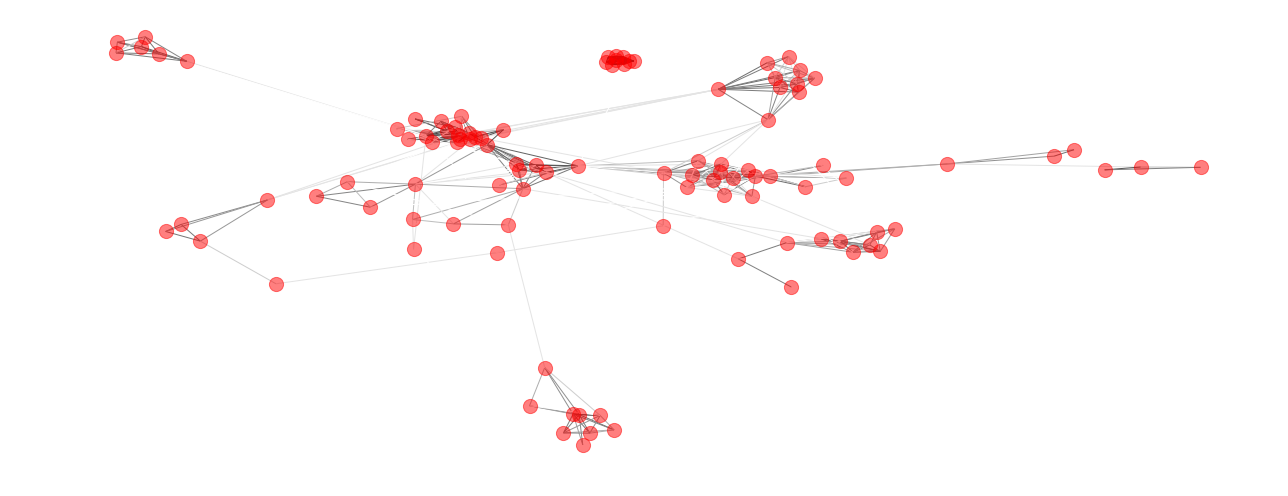

In [860]:
## 이제 그림을 그려줌
plt.figure(figsize=(18, 7))
#pos = nx.spring_layout(tempG)
nx.draw_networkx_nodes(tempG, pos=pos, node_size = 200,
                       cmap=plt.cm.gist_rainbow, 
                       alpha=0.5, labels={ n[0]:n[1]['community'] for n in tempG.nodes(data=True)},
                      )

edge_color = np.array([e[2]['weight'] for e in tempG.edges(data=True)])    
for j in range(0, 3):## normalization 
    edge_color = np.log1p(edge_color)
nx.draw_networkx_edges(tempG, pos=pos, edge_color = edge_color, edge_cmap= plt.cm.Greys, 
                       edge_vmin=edge_color.min(), edge_vmax=edge_color.max(), 
                      )

pos_min = (min((x for x, y in pos.values())), min((y for x, y in pos.values())))
pos_max = (max((x for x, y in pos.values())), max((y for x, y in pos.values())))

## 그려진 네트워크에 맞춰서 x, y 축을 조절 
plt.xlim(pos_min[0]-0.1, pos_max[0]+0.1)
plt.ylim(pos_min[1]-0.1, pos_max[1]+0.1)
plt.axis('off')
plt.tight_layout()
plt.savefig('../../assets/images/markdown_img/180809_network_original.png', dpi=200)
plt.show()

In [904]:
## 원래 그래프의 노드의 attribute에 community 정보를 넘겨줌
node_color = plt.cm.gist_rainbow(np.linspace(0, 1.0, len(community_lst[-1])))
for i, selected_community in enumerate(community_lst):
    ## 크기에 따라서 정렬 
    selected_community = sorted(selected_community, key=lambda x: "{:0>3d}_x[0]".format(len(x)), 
                                reverse=True)
    for j, comm in enumerate(selected_community):
        for p in comm: 
            tempG.nodes()[p]['community'] = j

    ## 이제 그림을 그려줌
    plt.figure(figsize=(18, 7))
    #pos = nx.spring_layout(tempG)
    nx.draw_networkx_nodes(tempG, pos=pos, node_size = 200,
                           node_color = [node_color[n[1]['community']] for n in tempG.nodes(data=True)], 
                           cmap=plt.cm.gist_rainbow, 
                           alpha=0.5, labels={ n[0]:n[1]['community'] for n in tempG.nodes(data=True)},
                          )

    edge_color = np.array([e[2]['weight'] for e in tempG.edges(data=True)])    
    for j in range(0, 3):## normalization 
        edge_color = np.log1p(edge_color)
    nx.draw_networkx_edges(tempG, pos=pos, edge_color = edge_color, edge_cmap= plt.cm.Greys, 
                           edge_vmin=edge_color.min(), edge_vmax=edge_color.max(), 
                          )
    
    pos_min = (min((x for x, y in pos.values())), min((y for x, y in pos.values())))
    pos_max = (max((x for x, y in pos.values())), max((y for x, y in pos.values())))

    ## 그려진 네트워크에 맞춰서 x, y 축을 조절 
    plt.xlim(pos_min[0]-0.1, pos_max[0]+0.1)
    plt.ylim(pos_min[1]-0.1, pos_max[1]+0.1)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../../assets/images/markdown_img/180809_network_community_change{}.png'.format(i), dpi=200)
    plt.close()
    #plt.show()
print("complete")

complete


In [903]:
for c in community_lst[7]:
    print(c)

{'김동석', '유세환', '조지현', '기완욱', '손영섭', '유온유', '이준호', '임정은', '이진연', '한은지', '홍준택', '남성현', '윤진성', '김대수', '김진우', '최인준', '김호겸', '이주석', '윤정현', '유택호', '김정택', '성상현', '임지택', '조민수', '이치헌', '백상현', '정윤선', '홍성철', '지봉준', '김한성', '이승록', '송민석'}
{'정화평', '이용문', '김건우', '황보순호', '김태훈', '류재현', '김대환', '김성래', '엄호용', '김규현', '민성용', '이기현', '서동진', '이태선', '이승렬', '빈영욱', '김준성', '권우경', '류성남', '이지환', '이동근'}
{'천은영', '김미현', '명진연', '조항현', '마리', '소담', '윤밍밍', '고철민', '강지우'}
{'김예원', '어머니', '이정호', '김재윤', '임소희', '송인영'}
{'이원형', '최수호', '유선겸', '송승민', '한주호', '서주환', '김범진', '윤석민', '김수빈'}
{'최혜진', '김성환', '박제현', '김영우', '안태훈', '장태웅', '박소연', '조성원', '송종혁'}
{'이시영', '신평식', '노명현', '윤치호', '엄태웅', '김상훈', '임석일', '김준연', '김범연', '양유동'}
{'진태원', '이동은', '박병희', '우성현', '이수현', '김수진'}
{'김해나', '정민우', '강보라', '문희경'}


In [689]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import itertools

sample_size = 100
x = np.vstack([
    np.random.normal(0, 1, sample_size).reshape(sample_size//2, 2), 
    np.random.normal(2, 1, sample_size).reshape(sample_size//2, 2), 
    np.random.normal(4, 1, sample_size).reshape(sample_size//2, 2)
])
y = np.array(list(itertools.chain.from_iterable([ [i+1 for j in range(0, sample_size//2)] for i in range(0, 3)])))
y = y.reshape(-1, 1)

df = pd.DataFrame(np.hstack([x, y]), columns=['x1', 'x2', 'y'])

c_lst = [plt.cm.rainbow(a) for a in np.linspace(0.0, 1.0, len(set(df['y'])))]

plt.figure(figsize=(12, 4))
for i, g in enumerate(df.groupby('y')):
    plt.scatter(g[1]['x1'], g[1]['x2'], color=c_lst[i], label='group {}'.format(int(g[0])), alpha=0.5)
plt.legend()
plt.show()

In [982]:
## burstness 
alcohol_date = np.array(list(sorted(set(raw_df[['술' in cat for cat in raw_df['category']]]['date']))))
alcohol_interval = alcohol_date[1:] - alcohol_date[0:-1]
alcohol_interval = np.array([intv/np.timedelta64(1, 'm') for intv in alcohol_interval])
#alcohol_date.iloc()[1:] - alcohol_date.iloc()[0:-1]
(alcohol_interval.std() - alcohol_interval.mean()) / (alcohol_interval.std() + alcohol_interval.mean())

-0.029941967170515719

In [1021]:
#### 상위 빈도 순위를 매기고 거기서 사람순으로 보자 
#### 그리고 burst 값으로 구분해볼 수 있을듯. 

## burstness는 -1, 1 사이의 값을 가지는데 값이 클수록 비정기적으로 만나고, 작을수록 정기적으로 만남 

burstness_lst = []
for p in [p for p, f in Counter(itertools.chain.from_iterable(raw_df.people)).most_common()]:
    times = np.array(list(sorted(set(raw_df[[ p in ps for ps in raw_df['people']]]['date']))))
    if len(times) > 20: 
        intervals = times[1:] - times[0:-1]
        intervals = np.array([ intv.total_seconds() for intv in intervals])
        m, std = intervals.mean(), intervals.std()
        burstness = (std-m)/(std+m)
        burstness_lst.append((p, len(times), burstness))
sorted(burstness_lst, key=lambda x: x[2], reverse=True)

[('이진연', 334, 0.67140748778981252),
 ('홍성철', 61, 0.65520089023903461),
 ('김진우', 461, 0.55326948589586655),
 ('김호겸', 338, 0.5488899932099055),
 ('김태훈', 171, 0.54632435901299037),
 ('임지택', 179, 0.4958783000580777),
 ('정윤선', 311, 0.48745083067341383),
 ('남성현', 36, 0.47794020373733093),
 ('기완욱', 31, 0.45759325731955025),
 ('이승록', 23, 0.42002181184296289),
 ('임소희', 127, 0.41227512636386832),
 ('홍준택', 58, 0.40109179209019136),
 ('천은영', 32, 0.37289702610259967),
 ('어머니', 178, 0.35458222015836605),
 ('이주석', 585, 0.35322823703952233),
 ('성상현', 454, 0.31290537583142475),
 ('최인준', 279, 0.27057996714199262),
 ('유세환', 71, 0.26431859233429539),
 ('윤정현', 129, 0.26017370912464172),
 ('유택호', 57, 0.25965253128805599),
 ('조항현', 102, 0.21899914943613852),
 ('김대환', 68, 0.19453159191093455),
 ('김규현', 92, 0.16586147189068681),
 ('김동석', 30, 0.16500726262835486),
 ('이정호', 74, 0.15075702563628962),
 ('빈영욱', 334, 0.1434783947704053),
 ('임정은', 33, 0.12967947986849046),
 ('이승렬', 295, 0.12537114353655052),
 ('이시영',

(array([ 0.,  0.,  0.,  0.,  0.]), array([ 1.,  2.,  1.,  1.,  1.]))

In [1006]:
raw_df[[ '유택호' in ps for ps in raw_df['people']]]['date']

38     2014-01-22
46     2014-01-27
147    2014-04-07
229    2014-05-24
287    2014-07-04
618    2015-02-05
627    2015-02-09
941    2015-05-29
943    2015-05-29
1022   2015-06-20
1023   2015-06-20
1068   2015-07-03
1074   2015-07-03
1091   2015-07-08
1123   2015-07-15
1151   2015-07-22
1315   2015-09-02
1358   2015-09-09
1719   2015-11-18
1724   2015-11-19
1725   2015-11-19
1727   2015-11-20
1769   2015-12-02
1866   2015-12-23
1986   2016-01-20
2047   2016-02-03
3121   2016-10-19
3372   2017-01-02
3403   2017-01-09
3404   2017-01-09
          ...    
3641   2017-03-20
3667   2017-03-27
3693   2017-04-03
3695   2017-04-03
3750   2017-04-17
3827   2017-05-08
3828   2017-05-08
3887   2017-05-24
3908   2017-05-29
3942   2017-06-05
4026   2017-06-26
4098   2017-07-17
4251   2017-09-04
4273   2017-09-11
4293   2017-09-18
4313   2017-09-25
4346   2017-10-10
4353   2017-10-11
4356   2017-10-12
4398   2017-10-23
4452   2017-11-06
4473   2017-11-13
4499   2017-11-20
4528   2017-11-27
4594   201